In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Wed Aug 26 21:15:59 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Mount the drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive/Colab\ Notebooks/NeuralODEs_ROM_Closure/neuralDDE_ROM_Closure

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/NeuralODEs_ROM_Closure/neuralDDE_ROM_Closure


In [3]:
%pip install quadpy

     |████████████████████████████████| 1.3MB 2.7MB/s 
     |████████████████████████████████| 51kB 6.3MB/s 



### Load modules

In [4]:
from src.utilities.DDE_Solver import ddeinttf 
import src.solvers.neuralDDE_with_adjoint as ndde

import time
import sys
import os
from IPython.core.debugger import set_trace

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from shutil import move

tf.keras.backend.set_floatx('float32')
import logging
tf.get_logger().setLevel(logging.ERROR)

## Define some useful classes

### Define a custom loss function

In [5]:
class custom_loss(tf.keras.losses.Loss):

    def call(self, true_y, pred_y):
        loss = tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.math.squared_difference(pred_y, true_y), axis=-1)), axis=0)
        return loss

### Define a custom plotting function

In [6]:
class custom_plot:

    def __init__(self, true_y, t, figsave_dir, args):
        self.true_y = true_y
        self.t = t
        self.figsave_dir = figsave_dir
        self.args = args

    def plot(self, *pred_y, epoch = 0):
        fig = plt.figure(figsize=(12, 4), facecolor='white')
        ax_traj = fig.add_subplot(121, frameon=False)
        ax_phase = fig.add_subplot(122, frameon=False)

        ax_traj.cla()
        ax_traj.set_title('Trajectories')
        ax_traj.set_xlabel('t')
        ax_traj.set_ylabel('x,y')
        ax_traj.plot(self.t.numpy(), self.true_y.numpy()[:, 0, 0], 'b-', self.t.numpy(), self.true_y.numpy()[:, 0, 1], 'g-')
        ax_traj.set_xlim(min(t.numpy()), max(t.numpy()))
        ax_traj.set_ylim(-1, 1)

        ax_phase.cla()
        ax_phase.set_title('Phase Portrait')
        ax_phase.set_xlabel('x')
        ax_phase.set_ylabel('y')
        ax_phase.plot(self.true_y.numpy()[:, 0, 0], self.true_y.numpy()[:, 0, 1], 'g-')
        ax_phase.set_xlim(-1, 1)
        ax_phase.set_ylim(-1, 1)  

        if epoch != 0 or self.args.restart == 1 :
            ax_traj.plot(self.t.numpy(), pred_y[0].numpy()[:, 0, 0], 'b--', self.t.numpy(), pred_y[0].numpy()[:, 0, 1], 'g--',)
            ax_phase.plot(pred_y[0].numpy()[:, 0, 0], pred_y[0].numpy()[:, 0, 1], 'g--')

        plt.show() 

        if epoch != 0: 
            fig.savefig(os.path.join(self.figsave_dir, 'img'+str(epoch)))

### Define the neural net architecture

In [7]:
class DDEFunc(tf.keras.Model):

    def __init__(self, **kwargs):
        super(DDEFunc, self).__init__(**kwargs)
        
        self.rnn_layer = tf.keras.layers.RNN(tf.keras.layers.SimpleRNNCell(2, activation='linear', use_bias=False, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1), 
                                                                        recurrent_initializer='random_normal'))
    
    def call(self, y, t, d):
        input = []
        for i in np.flip(np.arange(d[0])): # d is a list and d[0] contains the number of steps, while d[1] contains the time-step value to skip
            input.append(tf.expand_dims(y(t - i*d[1]), axis=0))

        input = tf.concat(input, axis=0)
        input = tf.transpose(input, perm=[1, 0] + [i for i in range(2, input.shape.rank)])
        y = input
        for i in range(len(self.layers)):
            y = self.layers[i](y)
        return y

### Initialize model related parameters

In [8]:
args = ndde.arguments(data_size = 1000, batch_time = 12, batch_time_skip = 2, batch_size = 5, epochs = 500, learning_rate = 0.075, decay_rate = 0.95, test_freq = 1, plot_freq = 2, 
                d_max = 1.1, rnn_nmax = 3, rnn_dt = 0.5, state_dim = 2, adj_data_size = 2,
                model_dir = 'DDE_runs/model_dir_example', restart = 0, val_percentage = 0.2)

t = tf.linspace(0., 10., args.data_size) # Time array

### Make a copy of the current script

In [9]:
%cd ..
if not os.path.exists(args.model_dir):
    os.makedirs(args.model_dir)

checkpoint_dir = os.path.join(args.model_dir, "ckpt")
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

figsave_dir = os.path.join(args.model_dir, "img")
if not os.path.exists(figsave_dir):
    os.makedirs(figsave_dir)

!jupyter nbconvert --to script 'neuralDDE_ROM_Closure/examples/neuralDDE_Example.ipynb'
move('neuralDDE_ROM_Closure/examples/neuralDDE_Example.txt', os.path.join(args.model_dir, "orig_run_file.py"))

/content/drive/My Drive/Colab Notebooks/NeuralODEs_ROM_Closure
[NbConvertApp] Converting notebook neuralDDE_ROM_Closure/examples/neuralDDE_Example.ipynb to script
[NbConvertApp] Writing 6624 bytes to neuralDDE_ROM_Closure/examples/neuralDDE_Example.txt


'DDE_runs/model_dir_example/orig_run_file.py'

### Define initial conditions and other parameters associated with the true DDE

In [10]:
class initial_cond(tf.keras.Model):

    def call(self, t):
        return tf.convert_to_tensor([[1., 0.]], dtype=tf.float32)

true_y0 = initial_cond() # Initial conditions
true_A = tf.convert_to_tensor([[-0.1, 2.0], [-2.0, -0.1]], dtype=tf.float32)
d = [0.5, 1.]

### Solve for the true DDE

In [11]:
class Lambda(tf.keras.Model):

    def call(self, y, t, d):
        return tf.cast(tf.einsum('ab, cb -> ca', tf.cast(tf.transpose(true_A), tf.float64), tf.cast(y(t), tf.float64)) 
            - 0.1*tf.einsum('ab, cb -> ca', tf.cast(tf.transpose(true_A), tf.float64), tf.cast(y(t - d[0]), tf.float64))
            - 0.1*tf.einsum('ab, cb -> ca', tf.cast(tf.transpose(true_A), tf.float64), tf.cast(y(t - d[1]), tf.float64)), tf.float32)
        
true_y = ddeinttf(Lambda(), true_y0, t, fargs=(d,))  # Solve for the true ODE solution

### Create validation set

In [12]:
val_obj = ndde.create_validation_set(true_y0, t, args)

val_true_y = val_obj.data(Lambda(), true_y, t, d)

## Main part starts here

### Make objects and define learning-rate schedule

In [13]:
time_meter = ndde.RunningAverageMeter(0.97)

func = DDEFunc()
adj_func = ndde.adj_eqn(func, args)
get_batch = ndde.create_batch(true_y, true_y0, t, args)
loss_obj = custom_loss()
plot_obj = custom_plot(true_y, t, figsave_dir, args)
loss_history = ndde.history(args)

initial_learning_rate = args.learning_rate
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=args.niters,
    decay_rate=args.decay_rate,
    staircase=True)

### Quick test to see how the true DDE looks like

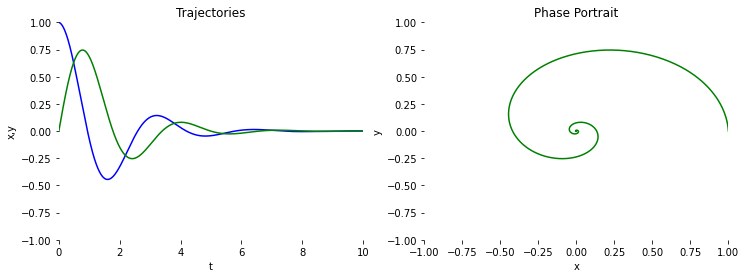

In [14]:
if args.restart == 1: 
    func.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
    pred_y = ddeinttf(func, true_y0, t, fargs=([args.rnn_nmax, args.rnn_dt],))
    
    plot_obj.plot(pred_y, epoch = 0)

    loss_history.read()
    
    initial_learning_rate = 0.05
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate, decay_steps=args.niters, decay_rate=0.93, staircase=True)
    
else:
    plot_obj.plot(epoch = 0)

### Training starts here

In [17]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate = lr_schedule)

nDDE_train_obj = ndde.train_nDDE(func = func, adj_func = adj_func, d = [args.rnn_nmax, args.rnn_dt], loss_obj = loss_obj, batch_obj = get_batch,
                            optimizer = optimizer, args = args, plot_obj = plot_obj, time_meter = time_meter, checkpoint_dir = checkpoint_prefix,
                            validation_obj = val_obj, loss_history_obj = loss_history)

nDDE_train_obj.train(true_y, true_y0, t, val_true_y)

Epoch 0000 | Train Loss 0.667333 | Val Loss 0.001151 | Time Elapsed 0.0000 mins
Epoch:  1  | Iteration:  1  | Learning Rate:  0.075


KeyboardInterrupt: ignored